<a href="https://colab.research.google.com/github/arazm21/ML-homework_4/blob/main/expression_notebook_first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# loading the data and organising it

In [1]:
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

Mounted at /content/drive
 88% 250M/285M [00:00<00:00, 618MB/s] 
100% 285M/285M [00:00<00:00, 574MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [2]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 15.8 MB/s eta 0:00:00


In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [4]:
import torch
from torch.utils.data import Dataset, Subset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Subset

class ExpressionDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, indices=None):
        self.data = pd.read_csv(csv_file)

        if indices is not None:
            self.data = self.data.iloc[indices].reset_index(drop=True)

        self.images = self.data['pixels'].apply(
            lambda x: np.fromstring(x, sep=' ', dtype=np.uint8).reshape(48, 48)
        )
        self.images = torch.tensor(np.stack(self.images.values), dtype=torch.float32).unsqueeze(1) / 255.0
        self.labels = torch.tensor(self.data['emotion'].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


def get_data(csv_file="train.csv", slice=5, train=True, val_ratio=0.2, random_state=42):
    # Load full train.csv data
    full_data = pd.read_csv(csv_file)
    indices = list(range(len(full_data)))

    # Stratified split indices for train/validation
    train_indices, val_indices = train_test_split(
        indices,
        test_size=val_ratio,
        stratify=full_data['emotion'],
        random_state=random_state
    )

    # Select which indices to use
    selected_indices = train_indices if train else val_indices

    # Create dataset with selected indices
    dataset = ExpressionDataset(csv_file, indices=selected_indices)

    # Slice dataset if requested
    sliced_indices = list(range(0, len(dataset), slice))
    return Subset(dataset, sliced_indices)


def make_loader(dataset, batch_size):
    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        pin_memory=True,
                        num_workers=2)
    return loader


## test that loading was ok

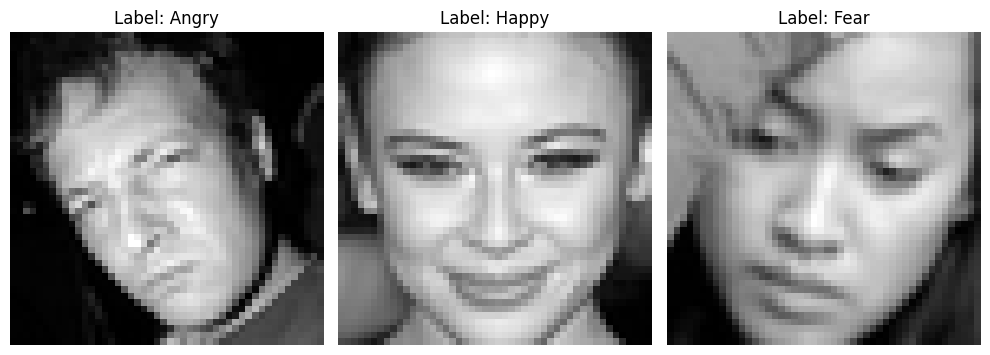

In [5]:
# Load and create loader
dataset = get_data(slice=1, train=False)
loader = make_loader(dataset, batch_size=3)

# Get a batch
images, labels = next(iter(loader))

# Class names from FER2013
emotion_names = [
    "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
]

# Plot the first 3 images
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {emotion_names[labels[i].item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# connecting WANDB

In [6]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arazm21 (arazm21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# different attempted architectures

In [16]:
# import torch.nn as nn

# class ConvNet_super_simple(nn.Module):
#     def __init__(self, kernels, classes=7):
#         super(ConvNet_super_simple, self).__init__()

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         # Assuming 48x48 input, after two 2x2 poolings -> 48/2/2 = 12x12
#         self.fc = nn.Linear(12 * 12 * kernels[1], classes)

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out
import torch
import torch.nn as nn

class ConvNet_Improved(nn.Module):
    def __init__(self, kernels, classes=7):
        super(ConvNet_Improved, self).__init__()

        # First conv block
        self.conv1 = nn.Conv2d(1, kernels[0], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(kernels[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second conv block
        self.conv2 = nn.Conv2d(kernels[0], kernels[1], kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(kernels[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third conv block
        self.conv3 = nn.Conv2d(kernels[1], kernels[2], kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(kernels[2])
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Assuming 48x48 input → 3 poolings: 48 → 24 → 12 → 6
        self.flattened_dim = 6 * 6 * kernels[2]
        self.fc = nn.Linear(self.flattened_dim, classes)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, num_blocks=5, num_classes=7):
        super(SimpleResNet, self).__init__()
        self.entry = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU()
        )

        self.blocks = nn.Sequential(*[ResidualBlock(base_channels) for _ in range(num_blocks)])

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_channels, num_classes)

    def forward(self, x):
        x = self.entry(x)
        x = self.blocks(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# geting everything ready

In [31]:
def make(config):
    # Make the data
    train_dataset = get_data(train=True)
    test_dataset = get_data(train=False)
    train_loader = make_loader(train_dataset, batch_size=config.batch_size)
    test_loader = make_loader(test_dataset, batch_size=config.batch_size)

    # Make the model
    model = SimpleResNet().to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    return model, train_loader, test_loader, criterion, optimizer

In [18]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

In [36]:
def train(model, loader, criterion, optimizer, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
                print(f"batch number: {batch_ct + 1}")


def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)

    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

In [20]:
def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {correct / total:%}")

        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

In [32]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="expression_dataset",
                    config=hyperparameters,
                    name = "simple_resnet_architecture"):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      # and use them to train the model
      train(model, train_loader, criterion, optimizer, config)

      # and test its final performance
      test(model, test_loader)

    return model

In [34]:
config = dict(
    epochs=50,
    classes=7,
    #kernels=[32, 64, 128],
    batch_size=256,
    learning_rate=0.005,
    dataset="Facial Expression Recognition",
    architecture="simple_resnet_architecture_50_epoch")

In [35]:
model = model_pipeline(config)

SimpleResNet(
  (entry): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )


  0%|          | 0/50 [00:00<?, ?it/s]

Loss after 01024 examples: 1.940
batch number: 5
Loss after 02304 examples: 1.822
batch number: 10
Loss after 03584 examples: 1.797
batch number: 15
Loss after 04850 examples: 1.821
batch number: 20
Loss after 06130 examples: 1.813
batch number: 25
Loss after 07410 examples: 1.777
batch number: 30
Loss after 08690 examples: 1.738
batch number: 35
Loss after 09956 examples: 1.776
batch number: 40
Loss after 11236 examples: 1.772
batch number: 45
Loss after 12516 examples: 1.823
batch number: 50
Loss after 13782 examples: 1.786
batch number: 55
Loss after 15062 examples: 1.744
batch number: 60
Loss after 16342 examples: 1.801
batch number: 65
Loss after 17622 examples: 1.797
batch number: 70
Loss after 18888 examples: 1.763
batch number: 75
Loss after 20168 examples: 1.785
batch number: 80
Loss after 21448 examples: 1.748
batch number: 85
Loss after 22728 examples: 1.812
batch number: 90
Loss after 23994 examples: 1.765
batch number: 95
Loss after 25274 examples: 1.750
batch number: 100


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
loss,███████▇▇█▇▇▇▇▇▆▇▆▆▆▆▆▅▆▅▅▄▄▅▄▄▃▃▃▃▃▂▂▂▁
test_accuracy,▁
epoch,49
loss,0.64389
test_accuracy,0.33768
